# Tutorial 3: Try PANNs CNN14 Variants

This tutorial shows examples:

- Using CNN14.
- Using CNN14 fusion variant proposed in our paper.


### ⚠ Setup before you proceed ⚠

If you have not setup, run the commands in [Setup-commands.txt](../Setup-commands.txt).

---
### 0.1 Making the notebook work better

First, setup autoloading of this notebook. Thanks to https://github.com/ipython/ipython/issues/9732

In [1]:
import IPython

from IPython import get_ipython
ipython = get_ipython()
ipython.magic('reload_ext autoreload')
ipython.magic('autoreload 2')
ipython.magic('matplotlib inline')

### 0.2 Adding path and import modules

We append root folder and EVAR folder to the system `path`.

In [2]:
import sys
sys.path.extend(['..', '../evar'])

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torchaudio

from IPython.display import display, Audio

## 1. Load CNN14

**DOWNLOAD CNN14 WEIGHTS BY YOURSELF**

Prepare your copy of weights under `../evar/external`.

```sh
wget https://zenodo.org/record/3987831/files/Cnn14_16k_mAP%3D0.438.pth
```

In [4]:
from gp_cnn14 import Cnn14_Decoupled, GeneralPurposeCnn14, AudioFeatureExtractor

model = Cnn14_Decoupled()
model.eval()
weights = torch.load('../evar/external/Cnn14_16k_mAP=0.438.pth', map_location=torch.device('cpu'))['model']
model.load_state_dict(weights, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['spectrogram_extractor.stft.conv_real.weight', 'spectrogram_extractor.stft.conv_imag.weight', 'logmel_extractor.melW', 'fc_audioset.weight', 'fc_audioset.bias'])

---
## 2. Load and convert audio clips to spectrograms

We use two animal voices. Thanks to Toro, a Shiba-Inu, and Haru, a black cat.

<table style="background-color:#FFFFFF;">
  <tr>
    <td valign="top"><img src="shibainu-toro.jpg" width="250" /></td>
    <td valign="top"><img src="cat-haru.jpg" width="200" /></td>
  </tr>
  <tr>
    <td style="text-align: center;">Toro</td>
    <td style="text-align: center;">Haru</td>
  </tr>
 </table>
 
 ### 2.1 Load audios

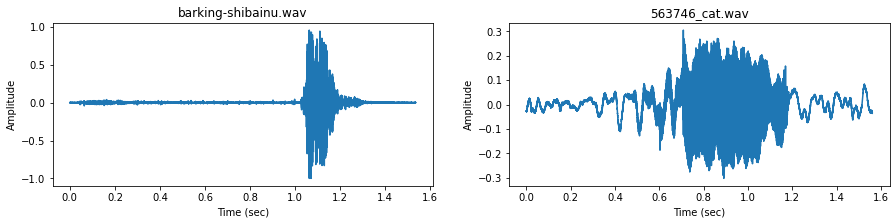

In [5]:
files = ['barking-shibainu.wav', '563746_cat.wav']

def load_sample_mono(file_name, display=True, subplot_idx=None):
    # loads audio in the shape of [channels, samples].
    wav, sr = torchaudio.load(file_name)
    # averages left and right channels into a single monoaural wave data.
    wav = wav.mean(0)

    if display:
        if subplot_idx:
            plt.subplot(subplot_idx)
        plt.plot(np.linspace(0.0, len(wav)/sr, len(wav)), wav)
        plt.xlabel('Time (sec)'); plt.ylabel('Amplitude');
        plt.title(file_name)
    return wav, sr

plt.figure(figsize=(15, 3))
wavs = []
wav, sr = load_sample_mono(files[0], subplot_idx=121)
assert sr == 44100, 'Make sure your audio is a 44.1kHz audio.'
wavs.append(wav)
wav, sr = load_sample_mono(files[1], subplot_idx=122)
assert sr == 44100, 'Make sure your audio is a 44.1kHz audio.'
wavs.append(wav)

### 2.2 Resample to 16kHz, the default sampling rate of the model we use

In [6]:
print('before', wavs[0].shape)
wavs = [torchaudio.functional.resample(wav, sr, 16000)
    for wav in wavs]
print('after', wavs[0].shape)

before torch.Size([67773])
after torch.Size([24589])


### 2.3 Trim

In [7]:
# find shortest length
min_length = min([wav.shape[-1] for wav in wavs])

# trim
wavs = [wav[:min_length] for wav in wavs]

# convert to PyTorch tensor for making further process easy.
wavs = torch.stack(wavs)

print(wavs.shape) # [Batch size, Freq. bins, Time frames]### 2.2 Resample to 16kHz, the default sampling rate of the model we use

torch.Size([2, 24589])


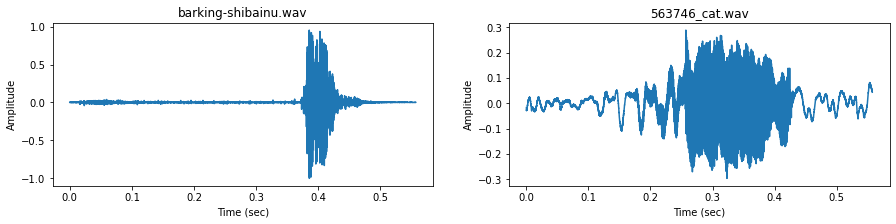

In [8]:
plt.figure(figsize=(15, 3))
for i, wav in enumerate(wavs):
    plt.subplot(121 + i)
    plt.plot(np.linspace(0.0, len(wav)/sr, len(wav)), wav)
    plt.xlabel('Time (sec)'); plt.ylabel('Amplitude');
    plt.title(files[i])

### 2.4 Convert to spectrogram

Cnn14 uses [torchlibrosa](https://github.com/qiuqiangkong/torchlibrosa). And we wrapped it as a utility class AudioFeatureExtractor in our `gp_cnn14.py`.

The shape `[2, 1, 154, 64]` means [Batch, Channel, Time frame, Frequency bin]. And the channel is always 1.

Cnn14 accepts variable-length audio.

In [9]:
feature_extractor = AudioFeatureExtractor()

X = feature_extractor(wavs)
X.shape

torch.Size([2, 1, 154, 64])

<ipython-input-10-3365091c54c2>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484782168/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  plt.imshow(x.T, origin='lower')


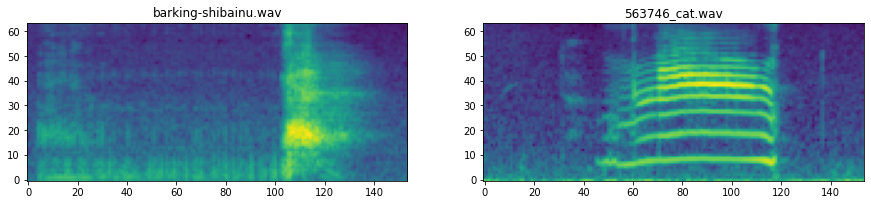

In [10]:
plt.figure(figsize=(15, 3))
for i, x in enumerate(X):
    plt.subplot(121 + i)
    plt.imshow(x.T, origin='lower')
    plt.title(files[i])

## 3. Encode audios

As CNN14 has BatchNorm inside, we do not normalize X.

We simply get clip-level features.

Shape of features: torch.Size([2, 2048])


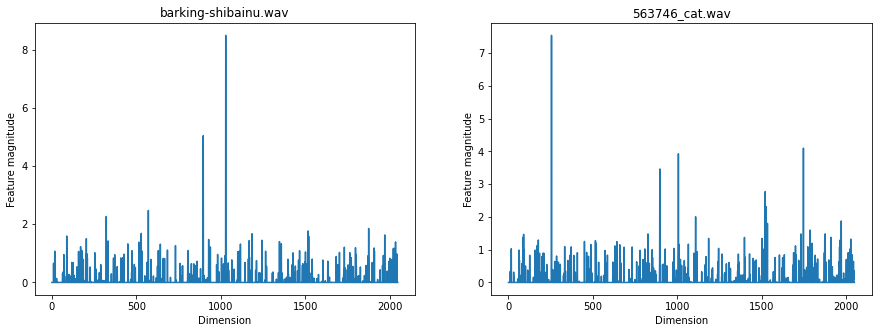

In [11]:
# encode 
features = model(X).detach()
print('Shape of features:', features.shape)

def plot_feature(x, subplot_idx=None, ylim=None):
    if subplot_idx:
        plt.subplot(subplot_idx)
    plt.plot(x)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel('Feature magnitude'); plt.xlabel('Dimension')

plt.figure(figsize=(15, 5))
for i in range(len(features)):
    plot_feature(features[i], subplot_idx=121 + i)
    plt.title(files[i])

## 4. Using GeneralPurposeCnn14

By default, this model fuses features from the layers [3, 6]. The layer 3 features have a higher magnitude, and the layer 6 features are lower range.

In [12]:
model = GeneralPurposeCnn14()
model.eval()
model.load_state_dict(weights, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['spectrogram_extractor.stft.conv_real.weight', 'spectrogram_extractor.stft.conv_imag.weight', 'logmel_extractor.melW', 'fc_audioset.weight', 'fc_audioset.bias'])

Shape of features: torch.Size([2, 6144])


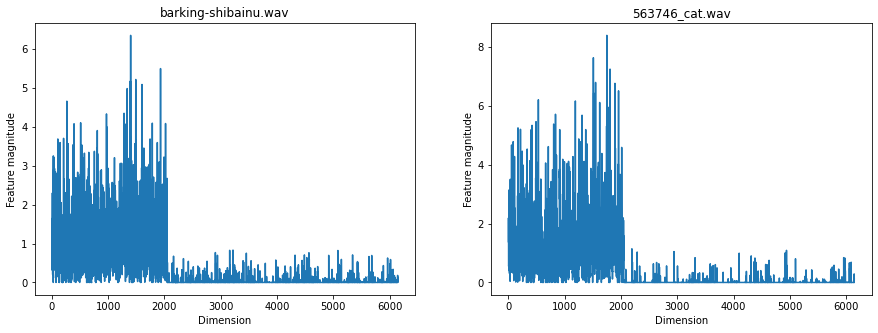

In [13]:
# encode 
features = model(X).detach()
print('Shape of features:', features.shape)

plt.figure(figsize=(15, 5))
for i in range(len(features)):
    plot_feature(features[i], subplot_idx=121 + i)
    plt.title(files[i])

### 4.1 Frame-level features

We can also encode to frame-level features. We get 4 feature frames for 154 time frames.

In [14]:
framed_features = model.encode_frames(X).detach()
framed_features.shape # [Batch, Dimension, Time frame]

torch.Size([2, 6144, 4])

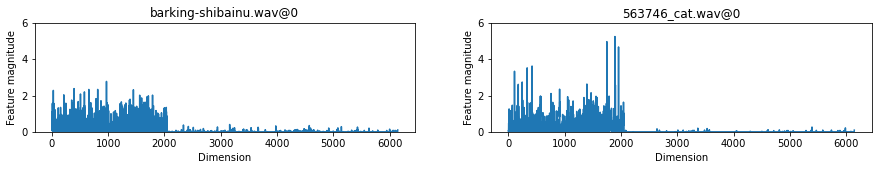

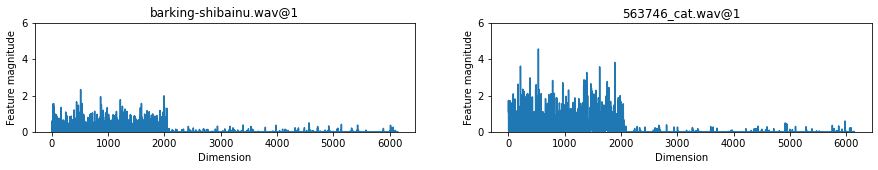

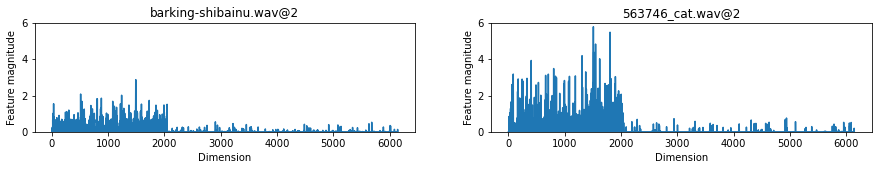

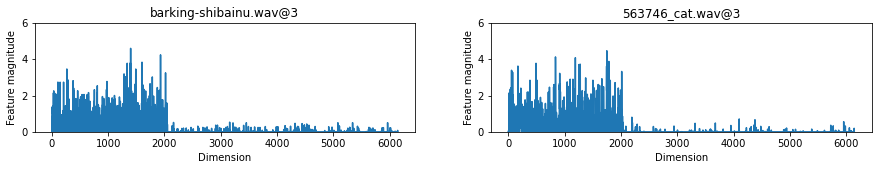

In [15]:
for t in range(framed_features.shape[-1]):
    plt.figure(figsize=(15, 2))
    for i in range(framed_features.shape[0]):
        plot_feature(framed_features[i, :, t], subplot_idx=121 + i, ylim=(0, 6))
        plt.title(files[i] + f'@{t}')
    plt.show()

### 4.2 Convert to a specific layer feature

Shape of features: torch.Size([2, 4096])


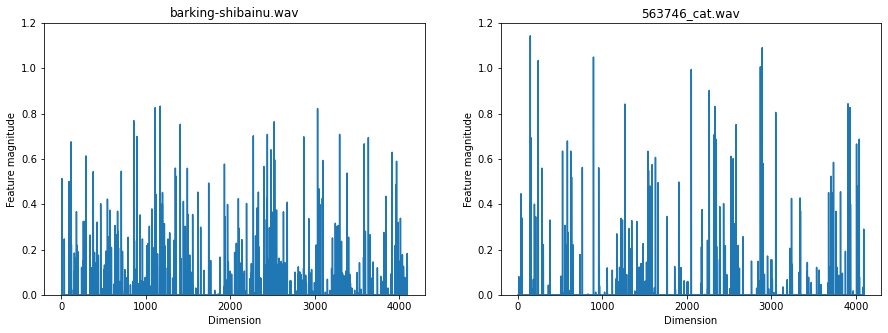

In [16]:
# encode 
features = model(X, layers=[6]).detach()
print('Shape of features:', features.shape)

plt.figure(figsize=(15, 5))
for i in range(len(features)):
    plot_feature(features[i], subplot_idx=121 + i, ylim=[0, 1.2])
    plt.title(files[i])

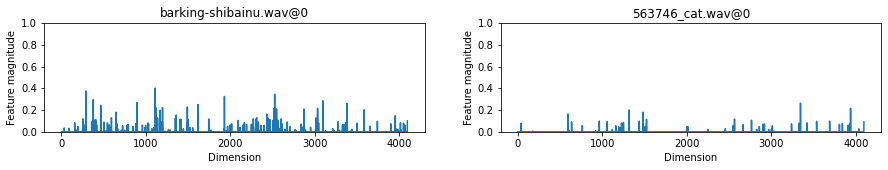

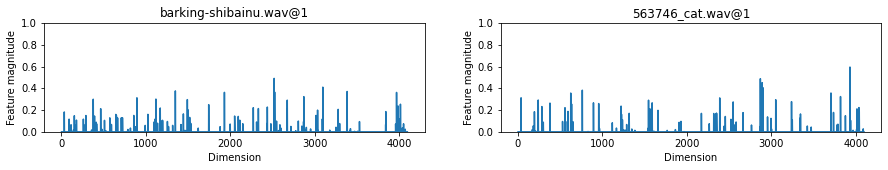

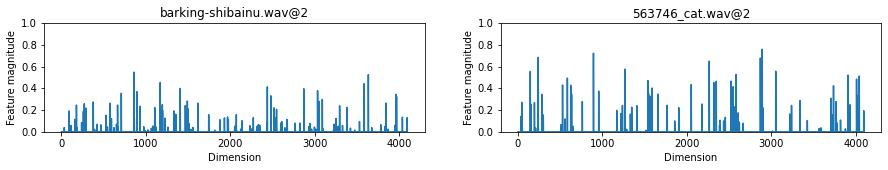

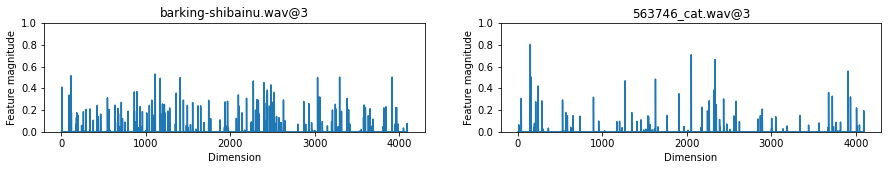

In [17]:
framed_features = model.encode_frames(X, layers=[6]).detach()
framed_features.shape # [Batch, Dimension, Time frame]

for t in range(framed_features.shape[-1]):
    plt.figure(figsize=(15, 2))
    for i in range(framed_features.shape[0]):
        plot_feature(framed_features[i, :, t], subplot_idx=121 + i, ylim=(0, 1.0))
        plt.title(files[i] + f'@{t}')
    plt.show()